# Metropolis-Hastings

## Integral of $e^{-|x^3|}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate

seed = 239
rng = np.random.default_rng(seed)

Acceptance fraction = 0.3596


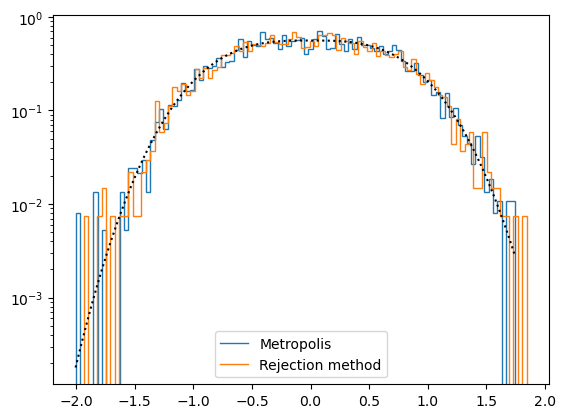

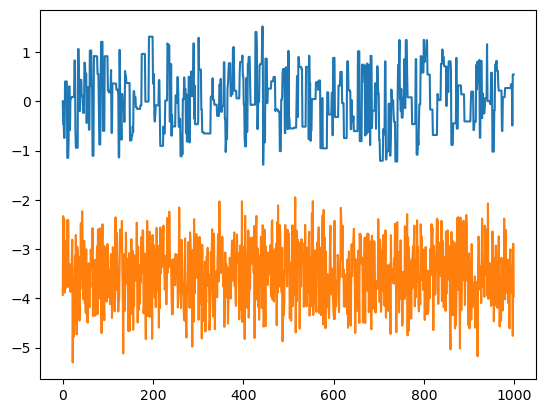

<Figure size 640x480 with 0 Axes>

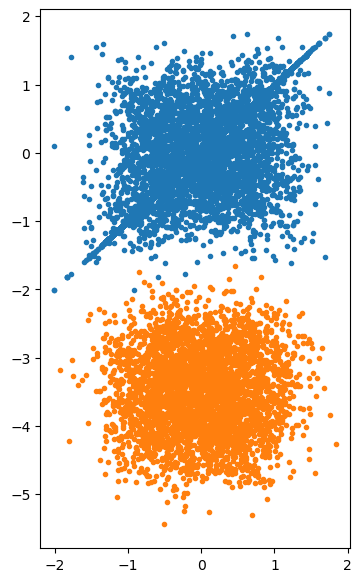

In [2]:
def f(x):
    return np.exp(-np.abs(x**3))

N = 10**4 # generate N samples

x = np.zeros(N)
x[0] = 0  # starting point

count = 0

for i in range(N-1):
    
    # Proposal
    x_try = x[i] + rng.normal(scale = 2)   

    # Accept the move or stay where we are
    u = rng.uniform()
    if u <= f(x_try) / f(x[i]):
        x[i+1] = x_try
        count = count + 1
    else:
        x[i+1] = x[i]

print("Acceptance fraction = %g" % (count/N,))

# Generate the same number of samples using the rejection method with uniform sampling
xmax = 4
xu = -xmax + 2*xmax*rng.uniform(size = 10*N)    # Generate x values between +-xmax
y = rng.uniform(size = 10*N)
xu = xu[np.where(y <= f(xu))]  
xu = xu[:count]
        
# Plot the distribution        
counts, bins = np.histogram(x, bins=100, density = True)
plt.stairs(counts, bins, label = 'Metropolis')    

counts, bins = np.histogram(xu, bins=100, density = True)
plt.stairs(counts, bins, label = 'Rejection method')    

norm,_ = scipy.integrate.quad(f,-np.inf,np.inf)
xx = np.linspace(min(x),max(x),1000)
plt.plot(xx, f(xx)/norm, 'k:')

plt.yscale('log')

plt.legend()
plt.show()

# Plot the first 1000 samples to see the time series
plt.clf()
t = np.arange(N)
plt.plot(t[:1000], x[:1000])
plt.plot(t[:1000], xu[:1000] - 3.5)
plt.show()

# Plot the point-to-point correlation
plt.clf()
plt.figure(figsize=(4,7))
plt.plot(x[:-1], x[1:], '.')
plt.plot(xu[:-1], xu[1:] - 3.5, '.')
plt.show()


Notes:

- We started at $x=0$ which is right in the middle of the high probability region. If instead you start at a point that has a low probability (e.g. try $x=-5$ as initial condition in line 7), you will see that the chain has a "burn in" period in which it moves towards the higher probability regions. The part of the chain should be discarded. 
- The time series for the MCMC shows clear correlations, whereas the rejection method samples are uncorrelated. This can be seen in the plot of $x_i$ vs $x_{i+1}$ -- in particular you can see the line of points where the proposed jump was not accepted.
- Try changing the `scale` in the normal distribution we're using for the jump and see how the acceptance ratio and the correlations behave. You want to choose a jump size that is large enough to explore the probability distribution, but small enough to get a reasonable acceptance rate for the jumps. An acceptance rate of around $0.2$--$0.3$ is good to aim for.

## Exoplanet orbit

In [3]:
def rv(t, P, x):
    # Calculates the radial velocity of a star orbited by a planet
    # at the times in the vector t
    
    # extract the orbit parameters
    # P, t and tp in days, mp in Jupiter masses, v0 in m/s  
    mp, e, omega, tp, v0 = x
        
    # mean anomaly
    M = 2*np.pi * (t-tp) / P
    
    # velocity amplitude
    K = 204 * P**(-1/3) * mp  / np.sqrt(1.0-e*e) # m/s
    
    # solve Kepler's equation for the eccentric anomaly E - e * np.sin(E) = M
    # Iterative method from Heintz DW, "Double stars", Reidel, 1978
    # first guess
    E = M + e*np.sin(M)  + ((e**2)*np.sin(2*M)/2)
    while True:
        E0 = E 
        M0 = E0 - e*np.sin(E0)
        E = E0 + (M-M0)/(1.0 - e*np.cos(E0))
        if np.max(np.abs((E-E0))) < 1e-6:
            break
        
    # evaluate the velocities
    theta = 2.0 * np.arctan( np.sqrt((1+e)/(1-e)) * np.tan(E/2))
    vel = v0 + K * ( np.cos(theta + omega) + e * np.cos(omega))
    
    return vel

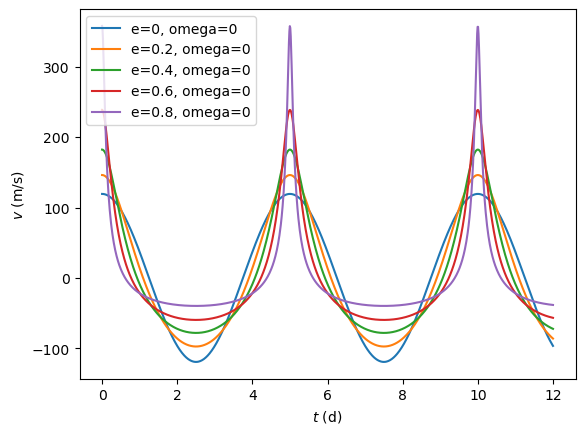

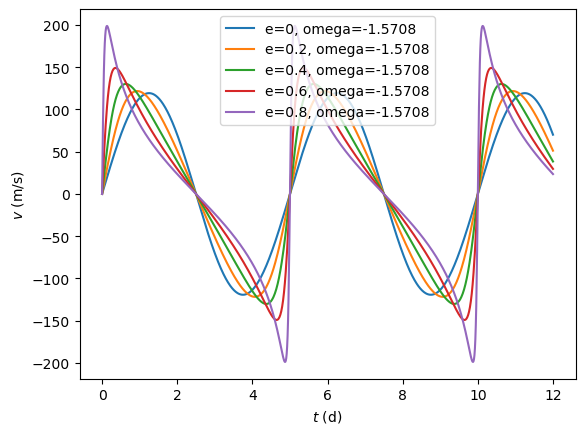

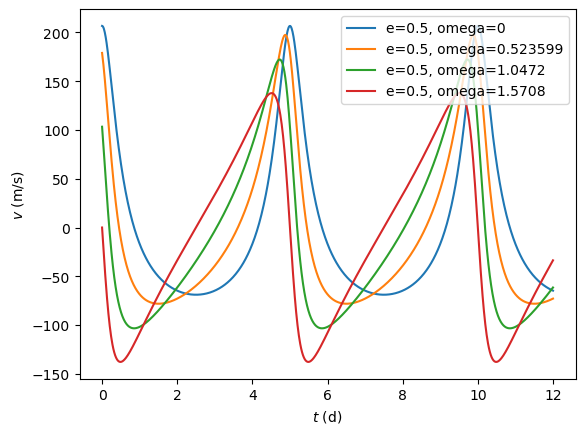

In [4]:
# Make some plots to show what the velocity curves look like
t = np.linspace(0,12,num=1000)

for e in np.arange(0.0,1.0,0.2):
    v = rv(t, 5.0, [1.0, e, 0.0, 0.0, 0.0])
    plt.plot(t,v, label='e=%g, omega=%g' % (e,0.0))

plt.ylabel(r'$v\ (\mathrm{m/s})$')
plt.xlabel(r'$t\ (\mathrm{d})$')
plt.legend()
plt.show()

plt.clf()
for e in np.arange(0.0,1.0,0.2):
    v = rv(t, 5.0, [1.0, e, -np.pi/2, 0.0, 0.0])
    plt.plot(t,v, label='e=%g, omega=%g' % (e,-np.pi/2))

plt.ylabel(r'$v\ (\mathrm{m/s})$')
plt.xlabel(r'$t\ (\mathrm{d})$')
plt.legend()
plt.show()

plt.clf
for omega in np.linspace(0.0,np.pi/2,4):
    v = rv(t, 5.0, [1.0, 0.5, omega, 0.0, 0.0])
    plt.plot(t,v, label='e=%g, omega=%g' % (0.5, omega))

plt.ylabel(r'$v\ (\mathrm{m/s})$')
plt.xlabel(r'$t\ (\mathrm{d})$')
plt.legend()
plt.show()

In [5]:
def f(x, tobs, vobs, eobs):
    chisq = np.sum(((vobs-rv(tobs, P, x))/eobs)**2)
    return -chisq/2

# Observations
# These are for HD145675 from Butler et al. 2003
tobs, vobs, eobs = np.loadtxt('rvs.txt', unpack=True)

# Number of samples to generate
N = 10**5
x = np.zeros((N, 5))

# initial guess
# P, mp, e, omega, tp, v0 
P = 1724
x[0] = [1.0, 0.0, 0.0, 0.0, 0.0]
# and the widths for the jumps
widths = (0.03, 0.03, 0.03, 3.0, 1.0)

count = 0

for i in range(N-1):
    
    # Proposal
    ii = np.random.randint(0, 5)
    x_try = np.copy(x[i])
    x_try[ii] += rng.normal(scale = widths[ii])

    #x_try[2] = (x_try[2]) % 1   # keep e between zero and 1
    
    # Accept the move or stay where we are
    u = rng.uniform()
    if u <= np.exp(f(x_try, tobs,vobs,eobs) - f(x[i], tobs,vobs,eobs)):
        x[i+1] = np.copy(x_try)
        count = count + 1
    else:
        x[i+1] = np.copy(x[i])

print("Acceptance fraction = %g" % (count/N,))

Acceptance fraction = 0.39897


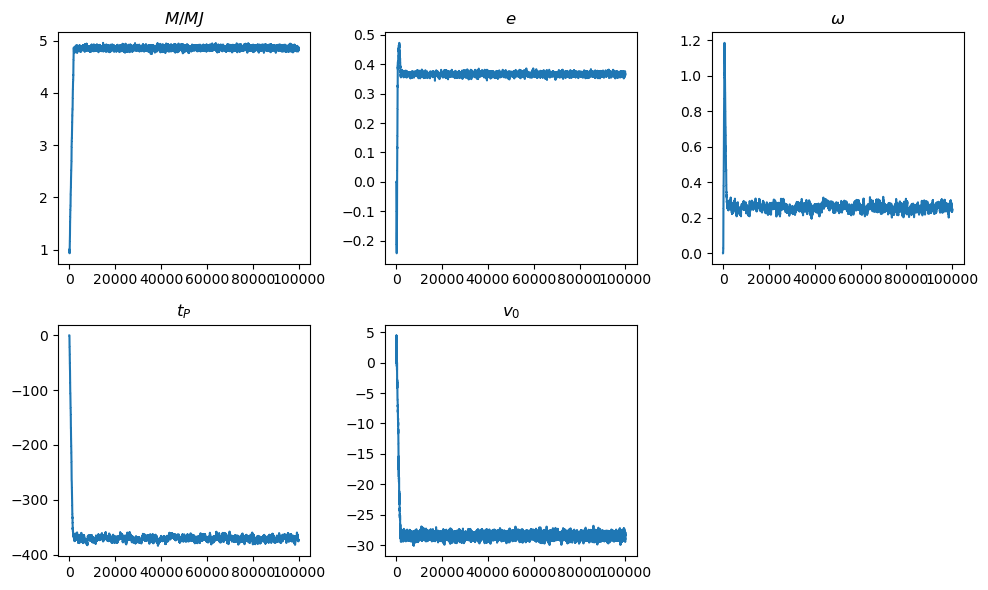

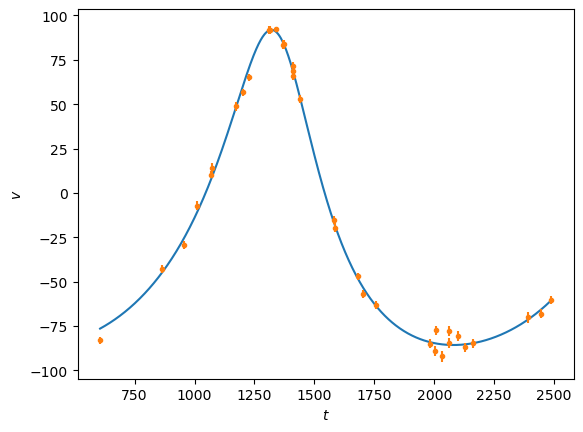

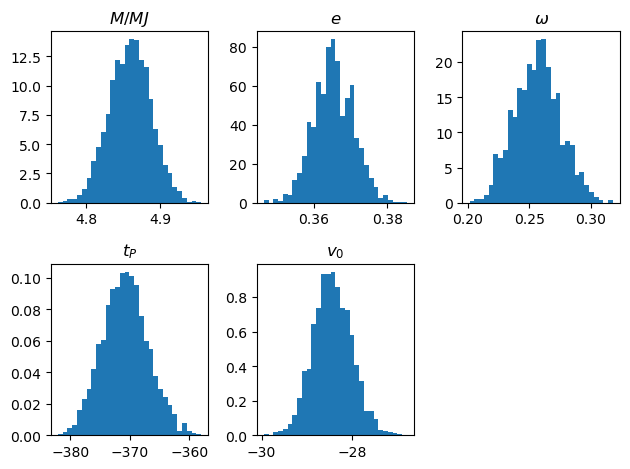

In [6]:
plt.figure(figsize=(10,6))

titles = (r'$M/MJ$', r'$e$', r'$\omega$', r'$t_P$', r'$v_0$')
for i, title in enumerate(titles):
    plt.subplot(2,3,i+1)
    plt.title(title)
    plt.plot(list(range(N)), x[:, i])
plt.tight_layout()
plt.show()

plt.clf()
t = np.linspace(tobs[0], tobs[-1], 1000)
plt.plot(t, rv(t,P, x[-1]), 'C0')
plt.plot(tobs, vobs, 'C1.')
plt.errorbar(tobs, vobs, eobs, fmt='none', ecolor='C1')
plt.ylabel(r'$v$')
plt.xlabel(r'$t$')
plt.show()

# Reject the burn in phase
x1 = x[int(0.5*N):]

plt.clf()
for i, title in enumerate(titles):
    plt.subplot(2,3,i+1)
    plt.title(title)
    plt.hist(x1[:, i], density=True, bins=30)
plt.tight_layout()
plt.show()


In [7]:
# https://corner.readthedocs.io/en/latest/
import corner

figure = corner.corner(x1, 
        labels = [r'$M/M_J$', r'$e$', r'$\omega$', r'$t_P$', r'$v_0$'], 
        show_titles=True)

ModuleNotFoundError: No module named 'corner'